##### Presentation Ideas
     * AB Testing to see how the model compares in the real world. 
         * Constrained by time. Validating predictions is on the scale of years
         * Average time to default is an interesting statistic to consider
         * some kind of visual for interesting features
     * Investigate prediction probabilities
          * where was the model confidently wrong
     * Regression test: predict percentagfe defaulted to determine how much the sba should commit to
         * may be more of an inferential task

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# investiagte dropping term years to see if

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    plot_roc_curve,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Replace with whatever model import(s) you're using
from xgboost import XGBClassifier


%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<IPython.core.display.Javascript object>

In [4]:
def print_vif(x):
    import warnings
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [5]:
loans = pd.read_csv("sba_loans_cleaned2.csv")
loans.info()

loans2 = pd.read_csv("data/sba_loans_cleaned3.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522582 entries, 0 to 522581
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               522582 non-null  object 
 1   BankState           522582 non-null  object 
 2   ApprovalFY          522582 non-null  int64  
 3   NoEmp               522582 non-null  int64  
 4   NewExist            522582 non-null  int64  
 5   RevLineCr           522049 non-null  float64
 6   LowDoc              518370 non-null  float64
 7   DisbursementGross   522582 non-null  float64
 8   MIS_Status          522582 non-null  int64  
 9   twoDigNAICS         522582 non-null  int64  
 10  is_franchise        522582 non-null  float64
 11  bank_out_of_state   522582 non-null  int64  
 12  Term_years          522582 non-null  float64
 13  job_category        522582 non-null  float64
 14  retained_category   522582 non-null  float64
 15  UrbanRural_cleaned  516078 non-nul

<IPython.core.display.Javascript object>

In [6]:
# loans.head()
loans2.head()

,State,BankState,ApprovalFY,NoEmp,NewExist,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,job_category,retained_category,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
0,NC,MN,2006,2,1,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,0.0,0.0,2006,0.866025,5.000000e-01,1.0,0.75,1.0,0.5,0.866025
1,AR,MS,2006,7,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,0.0,0.0,2006,1.000000,6.123234e-17,1.0,0.85,0.0,0.5,0.866025
2,CA,SD,2006,18,1,1.0,0.0,438541.0,0,61,0.0,0,6.916667,1.0,2.0,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
3,FL,FL,2006,4,0,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,1.0,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
4,LA,LA,2006,3,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,0.0,0.0,2006,0.866025,-5.000000e-01,1.0,0.85,0.0,0.5,0.866025


<IPython.core.display.Javascript object>

In [7]:
cat_cols = [
    "State",
    "BankState",
    "twoDigNAICS",
]

ordinal_cols = [
    "job_category",
    "retained_category",
    "bank_size",
]

num_cols = [
    # "ApprovalFY",
    "NoEmp",
    "DisbursementGross",
    "Term_years",  # untapped potential here
    "Disbr_year",  # may want to do some grouping by or transformation
]

bin_cols = ["NewExist", "is_franchise", "bank_out_of_state", "sba_pre_approv"]

other_cols = [
    "Disbr_Month_sin",
    "Disbr_Month_cos",
    "Appv_Month_sin",
    "Appv_Month_cos",
]  # not used, just documenting all cols

# information that won't exist until a decision is made by the SBA
sba_cols = [
    "Appv_Month_sin",
    "Appv_Month_cos",
    "sba_pre_approv",
    "percent_SBA",
    "ApprovalFY",
]  # turn off for loans

# impute_cols = [
#     "RevLineCr",
#     "LowDoc",
#     "UrbanRural_cleaned",
# ]

# dropping na's until the imputer is working
loans = loans.dropna()
loans2 = loans2.dropna()

<IPython.core.display.Javascript object>

In [8]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511771 entries, 0 to 522581
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               511771 non-null  object 
 1   BankState           511771 non-null  object 
 2   ApprovalFY          511771 non-null  int64  
 3   NoEmp               511771 non-null  int64  
 4   NewExist            511771 non-null  int64  
 5   RevLineCr           511771 non-null  float64
 6   LowDoc              511771 non-null  float64
 7   DisbursementGross   511771 non-null  float64
 8   MIS_Status          511771 non-null  int64  
 9   twoDigNAICS         511771 non-null  int64  
 10  is_franchise        511771 non-null  float64
 11  bank_out_of_state   511771 non-null  int64  
 12  Term_years          511771 non-null  float64
 13  job_category        511771 non-null  float64
 14  retained_category   511771 non-null  float64
 15  UrbanRural_cleaned  511771 non-nul

<IPython.core.display.Javascript object>

In [9]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]

<IPython.core.display.Javascript object>

In [10]:
print_vif(X.select_dtypes(include="number"))

VIF results
-------------------------------
const                 814829.290183
ApprovalFY                23.479557
NoEmp                      1.031137
NewExist                   1.116096
RevLineCr                  1.637751
LowDoc                     1.463996
DisbursementGross          1.440323
twoDigNAICS                1.062718
is_franchise               1.077374
bank_out_of_state          1.552891
Term_years                 1.726284
job_category               1.142698
retained_category          1.301262
UrbanRural_cleaned         1.085572
Disbr_year                23.010926
Disbr_Month_sin            2.115029
Disbr_Month_cos            1.924876
sba_pre_approv             1.136868
bank_size                  1.762733
percent_SBA                2.268133
Appv_Month_sin             1.949872
Appv_Month_cos             2.103376
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [11]:
# remove ApprovalFY. sba_pre_approv contains some of the same info, Disbr_year will also cover the loss
X = X.drop(columns="ApprovalFY")


<IPython.core.display.Javascript object>

In [12]:
print_vif(X.select_dtypes(include="number"))

VIF results
-------------------------------
const                 797312.671153
NoEmp                      1.030971
NewExist                   1.115743
RevLineCr                  1.614840
LowDoc                     1.463595
DisbursementGross          1.440158
twoDigNAICS                1.062572
is_franchise               1.076743
bank_out_of_state          1.551040
Term_years                 1.705217
job_category               1.140883
retained_category          1.297471
UrbanRural_cleaned         1.085415
Disbr_year                 1.280355
Disbr_Month_sin            1.938202
Disbr_Month_cos            1.903615
sba_pre_approv             1.119391
bank_size                  1.762614
percent_SBA                2.263075
Appv_Month_sin             1.940702
Appv_Month_cos             1.891943
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [13]:
X.isna().sum()

State                 0
BankState             0
NoEmp                 0
NewExist              0
RevLineCr             0
LowDoc                0
DisbursementGross     0
twoDigNAICS           0
is_franchise          0
bank_out_of_state     0
Term_years            0
job_category          0
retained_category     0
UrbanRural_cleaned    0
Disbr_year            0
Disbr_Month_sin       0
Disbr_Month_cos       0
sba_pre_approv        0
bank_size             0
percent_SBA           0
Appv_Month_sin        0
Appv_Month_cos        0
dtype: int64

<IPython.core.display.Javascript object>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<IPython.core.display.Javascript object>

In [15]:
preprocessing = ColumnTransformer(
    [
        ("leaveOneOut", LeaveOneOutEncoder(), cat_cols),
        ("scale", StandardScaler(), num_cols),  # never hurts
        # ("knnImptute", KNNImputer(n_neighbors=2), impute_cols),
        # ("simpleImptute", SimpleImputer(), impute_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [16]:
n_trees = 100
learning_rate = 2 / n_trees

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("xgbClass", XGBClassifier(n_estimators=n_trees, learning_rate=learning_rate)),
    ]
)

<IPython.core.display.Javascript object>

In [17]:
grid = {
    "xgbClass__subsample": [0.00125,0.0025, 0.01],
    #     "gbr__max_features": [0.5, 0.75, 1.0], # alternative
    "xgbClass__colsample_bytree": [0.6, 0.8, 1.0],
    "xgbClass__max_depth": [4, 6,7,8],
}



<IPython.core.display.Javascript object>

### Gradient Boost Classifier- 1st cleaning

In [18]:
# 2.6min runtime
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=2)
pipeline_cv.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.3min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [19]:
pipeline_cv.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 6,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [20]:
pipeline_cv.score(X_train, y_train)

0.9110929895682441

<IPython.core.display.Javascript object>

In [21]:
pipeline_cv.score(X_test, y_test)

0.9095378410698515

<IPython.core.display.Javascript object>

In [22]:
y_pred = pipeline_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     96216
           1       0.89      0.73      0.80     31727

    accuracy                           0.91    127943
   macro avg       0.90      0.85      0.87    127943
weighted avg       0.91      0.91      0.91    127943



<IPython.core.display.Javascript object>

In [23]:
confusion_matrix(y_test, y_pred, normalize="true")

array([[0.96885133, 0.03114867],
       [0.27033757, 0.72966243]])

<IPython.core.display.Javascript object>

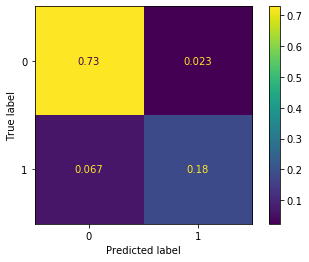

<IPython.core.display.Javascript object>

In [24]:
plot_confusion_matrix(pipeline_cv, X_test, y_test, normalize="all")

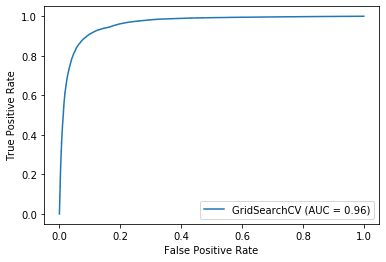

<IPython.core.display.Javascript object>

In [25]:
plot_roc_curve(pipeline_cv, X_test, y_test)

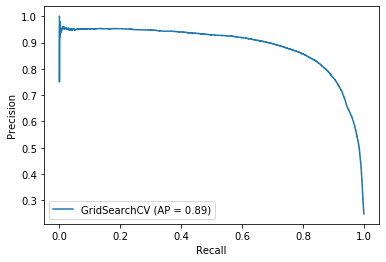

<IPython.core.display.Javascript object>

In [26]:
plot_precision_recall_curve(pipeline_cv, X_test, y_test)

In [27]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.232159
11,job_category,0.143981
18,bank_size,0.109795
1,BankState,0.086858
6,DisbursementGross,0.060709
19,percent_SBA,0.038821
9,bank_out_of_state,0.033184
8,is_franchise,0.030711
0,State,0.030584
4,RevLineCr,0.027530


<IPython.core.display.Javascript object>

In [28]:
pd.crosstab(loans["MIS_Status"], columns=loans["bank_size"], normalize="columns")

bank_size,0.0,1.0,2.0
MIS_Status,,,
0,0.8583,0.8639,0.702774
1,0.1417,0.1361,0.297226


<IPython.core.display.Javascript object>

In [29]:
pd.crosstab(
    loans["MIS_Status"], columns=loans["bank_out_of_state"], normalize="columns"
)

bank_out_of_state,0,1
MIS_Status,,
0,0.683016,0.848945
1,0.316984,0.151055


<IPython.core.display.Javascript object>

In [30]:
pd.crosstab(loans["MIS_Status"], columns=loans["bank_size"], normalize="columns")

bank_size,0.0,1.0,2.0
MIS_Status,,,
0,0.8583,0.8639,0.702774
1,0.1417,0.1361,0.297226


<IPython.core.display.Javascript object>

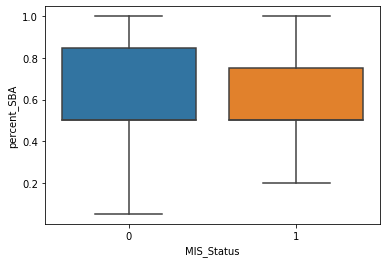

<IPython.core.display.Javascript object>

In [31]:
sns.boxplot(y="percent_SBA", x="MIS_Status", data=loans)
plt.show()

In [32]:
y.value_counts()

0    385081
1    126690
Name: MIS_Status, dtype: int64

<IPython.core.display.Javascript object>

### Gradient Boosting Classifier: 2nd cleaning

In [152]:
loans2 = loans2.dropna()
X = loans2.drop(columns=sba_cols)
X = X.drop(columns="MIS_Status")
y = loans2["MIS_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<IPython.core.display.Javascript object>

In [34]:
# 2.6min runtime
pipeline_cv_reclean = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=2)
pipeline_cv_reclean.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.0min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [35]:
pipeline_cv_reclean.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 6,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [36]:
pipeline_cv_reclean.score(X_train, y_train)

0.9040144268464796

<IPython.core.display.Javascript object>

In [37]:
pipeline_cv_reclean.score(X_test, y_test)

0.9042182844597774

<IPython.core.display.Javascript object>

In [38]:
y_pred = pipeline_cv_reclean.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     95782
           1       0.88      0.71      0.79     31758

    accuracy                           0.90    127540
   macro avg       0.90      0.84      0.86    127540
weighted avg       0.90      0.90      0.90    127540



<IPython.core.display.Javascript object>

In [39]:
confusion_matrix(y_test, y_pred, normalize="true")

array([[0.96927398, 0.03072602],
       [0.29198942, 0.70801058]])

<IPython.core.display.Javascript object>

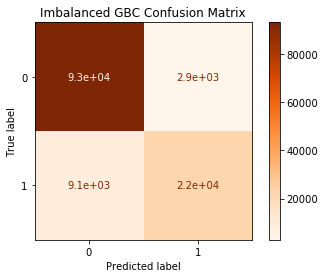

<IPython.core.display.Javascript object>

In [155]:
plot_confusion_matrix(pipeline_cv_reclean, X_test, y_test, cmap="Oranges")
plt.title("Imbalanced GBC Confusion Matrix")
plt.savefig("figs/imbalanced_cm.png")
plt.show()

In [150]:
y_test.value_counts()

0    96050
1    31490
Name: MIS_Status, dtype: int64

<IPython.core.display.Javascript object>

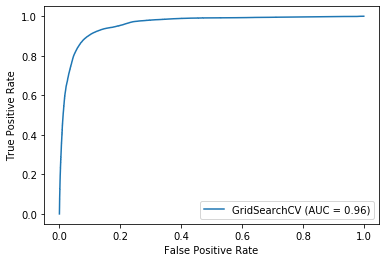

<IPython.core.display.Javascript object>

In [41]:
plot_roc_curve(pipeline_cv_reclean, X_test, y_test)

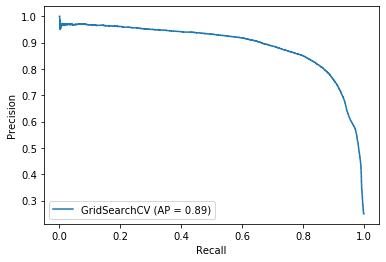

<IPython.core.display.Javascript object>

In [42]:
plot_precision_recall_curve(pipeline_cv_reclean, X_test, y_test)

In [43]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv_reclean.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.257086
11,job_category,0.163781
17,bank_size,0.100490
1,BankState,0.095376
6,DisbursementGross,0.066570
0,State,0.046464
8,is_franchise,0.036664
9,bank_out_of_state,0.035023
4,RevLineCr,0.028491
7,twoDigNAICS,0.026913


<IPython.core.display.Javascript object>

That model performed comparably to just guessing 0.

Due to the large class imbalance, the majority class will be down sampled to the size of the minority class. 

### Gradient Boosting Classifier: Resampled

In [189]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]
# remove ApprovalFY. sba_pre_approv contains some of the same info, Disbr_year will also cover the loss
X = X.drop(columns="ApprovalFY")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_1, replace=False, random_state=42)

# # Sample minority class to have less observations
# X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

X_train_resample = pd.concat((X_train_1, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n_1 + [0] * n_1)
y_train_resample.mean()

0.5

<IPython.core.display.Javascript object>

In [46]:
pipeline_cv_resample = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=3,)
pipeline_cv_resample.fit(X_train_resample, y_train_resample)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [47]:
pipeline_cv_resample.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 8,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [48]:
pipeline_cv_resample.score(X_train_resample, y_train_resample)

0.9051758656298076

<IPython.core.display.Javascript object>

In [49]:
pipeline_cv_resample.score(X_test, y_test)

0.8907091439156499

<IPython.core.display.Javascript object>

In [50]:
y_pred = pipeline_cv_resample.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     96155
           1       0.72      0.93      0.81     31788

    accuracy                           0.89    127943
   macro avg       0.84      0.90      0.87    127943
weighted avg       0.91      0.89      0.90    127943



<IPython.core.display.Javascript object>

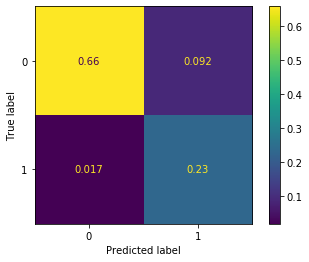

<IPython.core.display.Javascript object>

In [51]:
plot_confusion_matrix(pipeline_cv_resample, X_test, y_test, normalize="all")

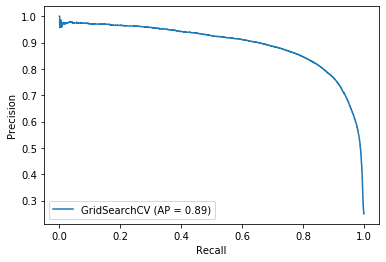

<IPython.core.display.Javascript object>

In [52]:
plot_precision_recall_curve(pipeline_cv_resample, X_test, y_test)

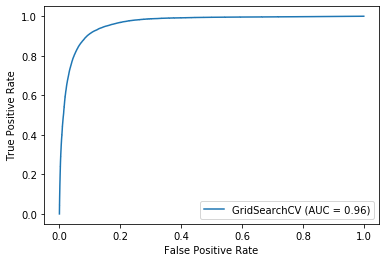

<IPython.core.display.Javascript object>

In [53]:
plot_roc_curve(pipeline_cv_resample, X_test, y_test)

In [192]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv_resample.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.263020
11,job_category,0.100600
1,BankState,0.071429
19,percent_SBA,0.057012
18,bank_size,0.055395
6,DisbursementGross,0.048811
8,is_franchise,0.042862
0,State,0.037129
17,sba_pre_approv,0.029406
4,RevLineCr,0.028455


<IPython.core.display.Javascript object>

### Gradient Boosting Classifier: 2nd Cleaning, Resample

In [128]:
loans2 = loans2.dropna()
X = loans2.drop(columns=sba_cols)
X = X.drop(columns="MIS_Status")
y = loans2["MIS_Status"]



<IPython.core.display.Javascript object>

In [56]:
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_1, replace=False, random_state=42)

# # Sample minority class to have less observations
# X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

X_train_resample = pd.concat((X_train_1, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n_1 + [0] * n_1)
y_train_resample.mean()

0.5

<IPython.core.display.Javascript object>

In [57]:
pipeline_cv_resample_reclean = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1, cv=3,)
pipeline_cv_resample_reclean.fit(X_train_resample, y_train_resample)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [58]:
pipeline_cv_resample_reclean.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 8,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [59]:
pipeline_cv_resample_reclean.score(X_train_resample, y_train_resample)

0.9024485200500858

<IPython.core.display.Javascript object>

In [60]:
pipeline_cv_resample_reclean.score(X_test, y_test)

0.8865532381997805

<IPython.core.display.Javascript object>

In [61]:
y_pred = pipeline_cv_resample_reclean.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92     96050
           1       0.71      0.93      0.80     31490

    accuracy                           0.89    127540
   macro avg       0.84      0.90      0.86    127540
weighted avg       0.91      0.89      0.89    127540



<IPython.core.display.Javascript object>

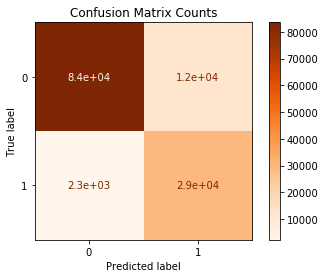

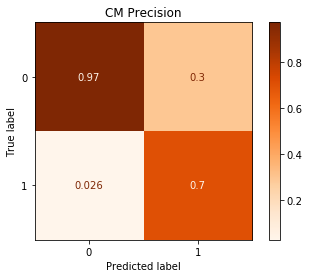

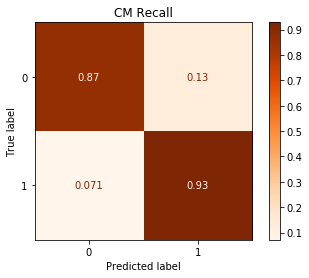

<IPython.core.display.Javascript object>

In [148]:
plot_confusion_matrix(
    pipeline_cv_resample_reclean, X_test, y_test, cmap="Oranges",
)
plt.title("Confusion Matrix Counts")

plt.savefig("figs/counts_loan_pred_con_matr.png")


plot_confusion_matrix(
    pipeline_cv_resample_reclean, X_test, y_test, normalize="pred", cmap="Oranges",
)
plt.title("CM Precision")

plt.savefig("figs/prec_loan_pred_con_matr.png")


plot_confusion_matrix(
    pipeline_cv_resample_reclean, X_test, y_test, normalize="true", cmap="Oranges",
)
plt.title("CM Recall")

plt.savefig("figs/recall_loan_pred_con_matr.png")

plt.show()

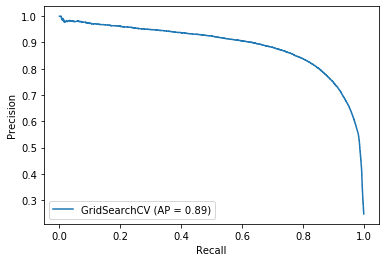

<IPython.core.display.Javascript object>

In [63]:
plot_precision_recall_curve(pipeline_cv_resample_reclean, X_test, y_test)

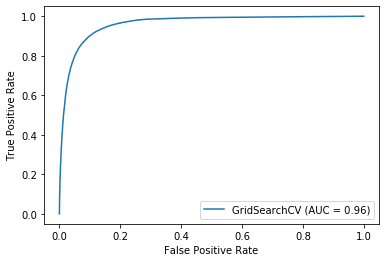

<IPython.core.display.Javascript object>

In [64]:
plot_roc_curve(pipeline_cv_resample_reclean, X_test, y_test)

In [157]:
importance_df = pd.DataFrame(
    {
        "Feature": X_train.columns,
        "Importance": pipeline_cv_resample_reclean.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("Importance", ascending=False)

,Feature,Importance
5,LowDoc,0.280424
11,job_category,0.133911
1,BankState,0.078828
6,DisbursementGross,0.055349
8,is_franchise,0.051034
17,bank_size,0.047374
0,State,0.042923
4,RevLineCr,0.034007
9,bank_out_of_state,0.032604
13,UrbanRural_cleaned,0.031403


<IPython.core.display.Javascript object>

In [159]:
pd.crosstab(loans2["MIS_Status"], columns=loans2["job_category"], normalize="columns")

job_category,0.0,1.0,2.0,3.0
MIS_Status,,,,
0,0.760818,0.725964,0.843943,0.76584
1,0.239182,0.274036,0.156057,0.23416


<IPython.core.display.Javascript object>

In [186]:
loans2.groupby(by=["MIS_Status"]).agg(
    {"DisbursementGross": ["mean", "median"]}, axis="columns"
)

DisbursementGross         
                        mean   median
MIS_Status                           
0              209783.519929  87300.0
1              115712.153896  51437.0

<IPython.core.display.Javascript object>

In [160]:
loans2["job_category"].value_counts()

0.0    303902
1.0    183275
2.0     22620
3.0       363
Name: job_category, dtype: int64

<IPython.core.display.Javascript object>

In [66]:
pd.crosstab(loans["MIS_Status"], columns=loans["LowDoc"], normalize="columns")
# awarded based on cash flow!!!
# https://www.entrepreneur.com/encyclopedia/lowdoc

LowDoc,0.0,1.0
MIS_Status,,
0,0.746469,0.847128
1,0.253531,0.152872


<IPython.core.display.Javascript object>

In [67]:
pd.crosstab(loans["MIS_Status"], columns=loans["NewExist"], normalize="columns")

NewExist,0,1
MIS_Status,,
0,0.753663,0.7494
1,0.246337,0.2506


<IPython.core.display.Javascript object>

In [182]:
disbursement_job_cat = loans2.groupby(by=["MIS_Status", "job_category"]).agg(
    {"DisbursementGross": ["mean"]}, axis="columns"
)

disbursement_job_cat

DisbursementGross
                                     mean
MIS_Status job_category                  
0          0.0              182812.974764
           1.0              207432.557470
           2.0              546046.725930
           3.0              675614.215827
1          0.0              115908.084484
           1.0              102778.993390
           2.0              289816.184986
           3.0              359547.694118

<IPython.core.display.Javascript object>

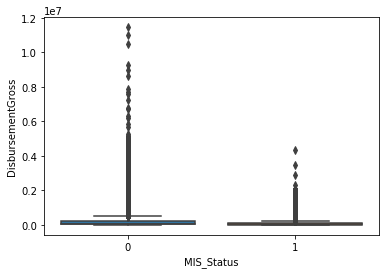

<IPython.core.display.Javascript object>

In [69]:
sns.boxplot(y="DisbursementGross", x="MIS_Status", data=loans)
plt.show()

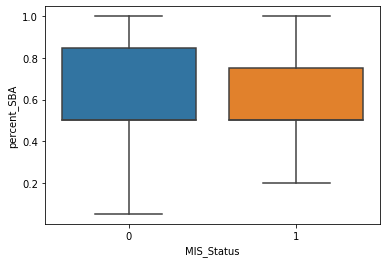

<IPython.core.display.Javascript object>

In [70]:
sns.boxplot(y="percent_SBA", x="MIS_Status", data=loans)

### Gradient Boosting Classifier: Resampled, F1 Scoring

In [77]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]
# remove ApprovalFY. sba_pre_approv contains some of the same info, Disbr_year will also cover the loss
X = X.drop(columns="ApprovalFY")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]

n_0 = X_train_0.shape[0]
n_1 = X_train_1.shape[0]

# Sample majority class to have less observations
X_train_0_sample = X_train_0.sample(n_1, replace=False, random_state=42)

# # Sample minority class to have less observations
# X_train_1_sample = X_train_1.sample(n, replace=True, random_state=42)

X_train_resample = pd.concat((X_train_1, X_train_0_sample))
X_train_resample = X_train_resample.reset_index(drop=True)

y_train_resample = np.array([1] * n_1 + [0] * n_1)
y_train_resample.mean()


0.5

<IPython.core.display.Javascript object>

In [78]:
pipeline_cv_resample_f1 = GridSearchCV(
    pipeline, grid, verbose=1, n_jobs=-1, cv=3, scoring="f1"
)
pipeline_cv_resample_f1.fit(X_train_resample, y_train_resample)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  4.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [79]:
pipeline_cv_resample_f1.best_params_

{'xgbClass__colsample_bytree': 1.0,
 'xgbClass__max_depth': 8,
 'xgbClass__subsample': 0.01}

<IPython.core.display.Javascript object>

In [80]:
pipeline_cv_resample_f1.score(X_train_resample, y_train_resample)

0.9062891145993639

<IPython.core.display.Javascript object>

In [81]:
pipeline_cv_resample_f1.score(X_test, y_test)

0.805397844153707

<IPython.core.display.Javascript object>

In [82]:
y_pred = pipeline_cv_resample_f1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     96267
           1       0.71      0.93      0.81     31676

    accuracy                           0.89    127943
   macro avg       0.84      0.90      0.86    127943
weighted avg       0.91      0.89      0.89    127943



<IPython.core.display.Javascript object>

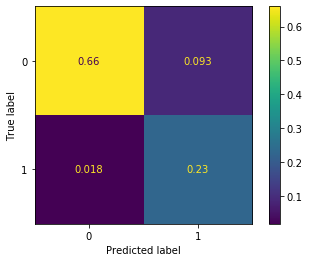

<IPython.core.display.Javascript object>

In [83]:
plot_confusion_matrix(pipeline_cv_resample_f1, X_test, y_test, normalize="all")

In [84]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": pipeline_cv_resample_f1.best_estimator_.named_steps[
            "xgbClass"
        ].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.249604
11,job_category,0.148425
1,BankState,0.068720
19,percent_SBA,0.051804
6,DisbursementGross,0.046672
18,bank_size,0.042928
8,is_franchise,0.037214
0,State,0.034602
4,RevLineCr,0.028843
7,twoDigNAICS,0.026411


<IPython.core.display.Javascript object>

In [85]:
rf_grid = {
    "rf__max_depth": [4, 5, 6],
    "rf__min_samples_split": [0.1, 0.2, 0.3],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.25, 0.5, 0.75],
}

<IPython.core.display.Javascript object>

In [86]:
rf_pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('rf', RandomForestClassifier())
    ])


<IPython.core.display.Javascript object>

In [87]:
rf_cv = GridSearchCV(rf_pipeline, rf_grid, cv=2, n_jobs=-1, verbose=1)

<IPython.core.display.Javascript object>

In [88]:
# rf_cv.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [89]:
# rf_cv.best_params_

<IPython.core.display.Javascript object>

In [90]:
rf_grid2 = {
    "rf__max_depth": [5],
    "rf__min_samples_split": [0.01, 0.05, 0.1, 0.2],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.7, 0.8, 0.9, 1.0],
}

<IPython.core.display.Javascript object>

In [91]:
# rf_cv2 = GridSearchCV(rf_pipeline, rf_grid2, cv=2, n_jobs=-1, verbose=1)

<IPython.core.display.Javascript object>

In [92]:
# rf_cv2.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [93]:
# rf_cv2.best_params_

<IPython.core.display.Javascript object>

In [94]:
rf_grid3 = {
    "rf__max_depth": [5],
    "rf__min_samples_split": [100, 500, 1000, 10000],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.8],
}

<IPython.core.display.Javascript object>

In [95]:
rf_cv3 = GridSearchCV(rf_pipeline, rf_grid3, cv=2, n_jobs=-1, verbose=1)

<IPython.core.display.Javascript object>

In [96]:
rf_cv3.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.6min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [97]:
rf_cv3.best_params_

{'rf__max_depth': 5, 'rf__max_features': 0.8, 'rf__min_samples_split': 1000}

<IPython.core.display.Javascript object>

In [98]:
rf_cv3.score(X_train, y_train)

0.8910449472159405

<IPython.core.display.Javascript object>

In [99]:
rf_cv3.score(X_test, y_test)

0.8912015506905419

<IPython.core.display.Javascript object>

In [100]:
y_pred = rf_cv3.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     96267
           1       0.82      0.72      0.77     31676

    accuracy                           0.89    127943
   macro avg       0.87      0.83      0.85    127943
weighted avg       0.89      0.89      0.89    127943



<IPython.core.display.Javascript object>

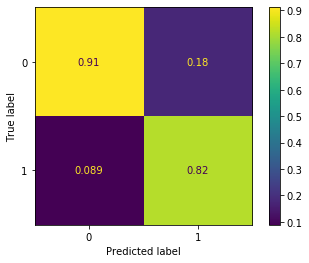

<IPython.core.display.Javascript object>

In [101]:
plot_confusion_matrix(rf_cv3, X_test, y_test, normalize="pred")

In [102]:
importance_df = pd.DataFrame(
    {
        "feat": X_train.columns,
        "importance": rf_cv3.best_estimator_.named_steps["rf"].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,0.806561
1,BankState,0.078524
11,job_category,0.045740
6,DisbursementGross,0.038977
18,bank_size,0.012070
19,percent_SBA,0.007022
0,State,0.005862
4,RevLineCr,0.003798
8,is_franchise,0.001293
17,sba_pre_approv,0.000082


<IPython.core.display.Javascript object>

In [103]:
rf_grid4 = {
    "rf__max_depth": [5, 6, 7],
    "rf__min_samples_split": [1000, 2000],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "rf__max_features": [0.8],
}
rf_cv4 = GridSearchCV(rf_pipeline, rf_grid4, cv=2, n_jobs=-1, verbose=1)
rf_cv4.fit(X_train_resample, y_train_resample)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   59.1s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [104]:
rf_cv4.best_params_

{'rf__max_depth': 6, 'rf__max_features': 0.8, 'rf__min_samples_split': 1000}

<IPython.core.display.Javascript object>

In [105]:
rf_cv4.score(X_train_resample, y_train_resample)

0.8885216915401941

<IPython.core.display.Javascript object>

In [106]:
rf_cv4.score(X_test, y_test)

0.8688087664037892

<IPython.core.display.Javascript object>

In [107]:
y_pred = rf_cv4.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     96267
           1       0.67      0.93      0.78     31676

    accuracy                           0.87    127943
   macro avg       0.82      0.89      0.84    127943
weighted avg       0.90      0.87      0.87    127943



<IPython.core.display.Javascript object>

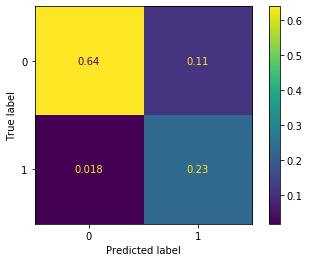

<IPython.core.display.Javascript object>

In [108]:
plot_confusion_matrix(rf_cv4, X_test, y_test, normalize="all")

In [109]:
importance_df = pd.DataFrame(
    {
        "feat": X_train_resample.columns,
        "importance": rf_cv4.best_estimator_.named_steps["rf"].feature_importances_,
    }
)

importance_df.sort_values("importance", ascending=False)

,feat,importance
5,LowDoc,8.426108e-01
1,BankState,5.776013e-02
11,job_category,2.909776e-02
6,DisbursementGross,2.641008e-02
19,percent_SBA,1.744440e-02
0,State,1.343613e-02
4,RevLineCr,5.418557e-03
18,bank_size,4.973467e-03
8,is_franchise,2.660013e-03
9,bank_out_of_state,1.075977e-04


<IPython.core.display.Javascript object>

In [110]:
logreg_pipe = Pipeline([("preprocessing", preprocessing), ("lr", LogisticRegression())])

<IPython.core.display.Javascript object>

In [111]:
lr_grid = {"lr__penalty": ["l2"], "lr__C": [0.01, 0.1, 1]}

<IPython.core.display.Javascript object>

In [112]:
lr_cv = GridSearchCV(logreg_pipe, lr_grid, cv=2, verbose=1, n_jobs=-1)


<IPython.core.display.Javascript object>

In [113]:
lr_cv.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.7s finished
C:\Users\dgump\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [114]:
lr_cv.best_params_

{'lr__C': 1, 'lr__penalty': 'l2'}

<IPython.core.display.Javascript object>

In [115]:
lr_cv.score(X_train, y_train)

0.8404102879414738

<IPython.core.display.Javascript object>

In [116]:
lr_cv.score(X_test, y_test)

0.8389126407853498

<IPython.core.display.Javascript object>

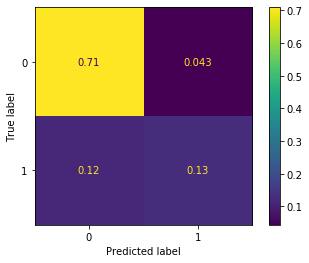

<IPython.core.display.Javascript object>

In [117]:
plot_confusion_matrix(lr_cv, X_test, y_test, normalize="all")

In [118]:
lr_cv.fit(X_train_resample, y_train_resample)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.1s finished
C:\Users\dgump\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('leaveOneOut',
                                                                         LeaveOneOutEncoder(cols=None,
                                                                                            drop_invariant=False,
                                                                                            handle_missing='value',
                                                                                            handle_unknown='value',
       

<IPython.core.display.Javascript object>

In [119]:
lr_cv.score(X_train_resample, y_train_resample)

0.8092544256635864

<IPython.core.display.Javascript object>

In [120]:
lr_cv.score(X_test, y_test)

0.7954245249837818

<IPython.core.display.Javascript object>

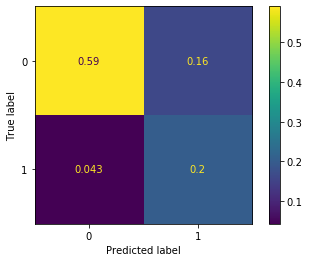

<IPython.core.display.Javascript object>

In [121]:
plot_confusion_matrix(lr_cv, X_test, y_test, normalize="all")

In [122]:
y_pred = lr_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85     96267
           1       0.56      0.83      0.67     31676

    accuracy                           0.80    127943
   macro avg       0.75      0.81      0.76    127943
weighted avg       0.84      0.80      0.81    127943



<IPython.core.display.Javascript object>

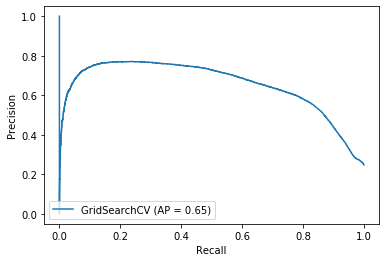

<IPython.core.display.Javascript object>

In [123]:
plot_precision_recall_curve(lr_cv, X_test, y_test)

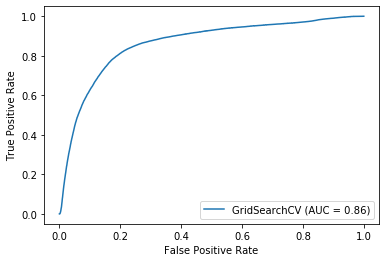

<IPython.core.display.Javascript object>

In [124]:
plot_roc_curve(lr_cv, X_test, y_test)